In [66]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net, MLP

In [67]:
n_epoch = 1000000 #エポック
batchsize = 5000 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [68]:
xp = cuda.cupy if use_gpu is True else np

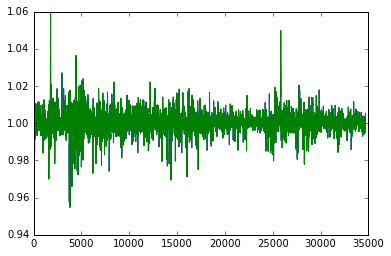

In [69]:
raw_data = []
f = open('nikkei5min.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    if row[7] == "":
        continue
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

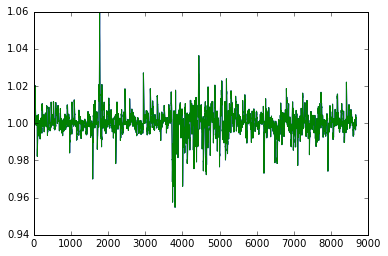

In [70]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [71]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(chainer.Variable(xp.asarray([[x_] for x_ in x])))
    error = F.mean_squared_error(out, chainer.Variable(xp.asarray([[y] for y in y], dtype=np.float32)))
    return chainer.cuda.to_cpu(out.data), error.data

In [72]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 1000 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data * len(x) / length))
        #loss.append(loss_data * batchsize / length)
        
        loss.append(evaluate(model, train_data_x, train_data_y)[1])
        test_loss.append(evaluate(model, test_data_x, test_data_y)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1000, error 1.4459625482559204
epoch 2000, error 0.0023060892708599567
epoch 3000, error 0.0018315187189728022
epoch 4000, error 0.0020127862226217985
epoch 5000, error 0.0017914155032485723
epoch 6000, error 0.0019323149463161826
epoch 7000, error 0.0014466563006862998
epoch 8000, error 0.0018623039359226823
epoch 9000, error 0.0018109267111867666
epoch 10000, error 0.001925525488331914
epoch 11000, error 0.0018603618955239654
epoch 12000, error 0.0017847049748525023
epoch 13000, error 0.0014936983352527022
epoch 14000, error 0.0017800723435357213
epoch 15000, error 0.0018444788875058293
epoch 16000, error 0.0018057014094665647
epoch 17000, error 0.0018630619160830975
epoch 18000, error 0.0016262042336165905
epoch 19000, error 0.0016843006014823914
epoch 20000, error 0.0017143434379249811
epoch 21000, error 0.001870176987722516
epoch 22000, error 0.0017368887783959508
epoch 23000, error 0.0018699780339375138
epoch 24000, error 0.0013649922329932451
epoch 25000, error 0.001697654

KeyboardInterrupt: 

In [73]:
#モデルを保存
serializers.save_npz('my.model', model)

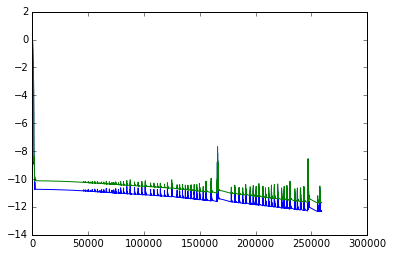

In [74]:
plt.plot([math.log(x) for x in loss])
plt.plot([math.log(x) for x in test_loss])

In [75]:
output, error = evaluate(model, train_data_x, train_data_y)

print(error)

4.485051704250509e-06


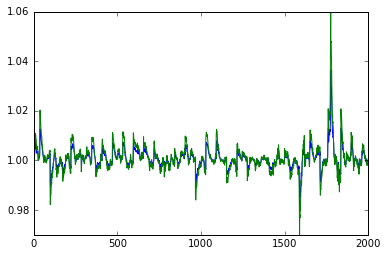

In [76]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

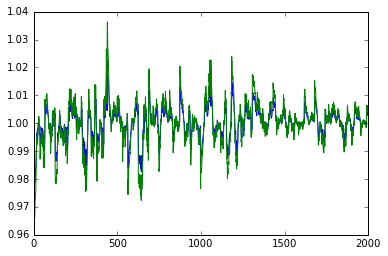

In [77]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [78]:
output, error = evaluate(model, test_data_x, test_data_y)
print('test error = {}'.format(error))

test error = 8.27493659016909e-06


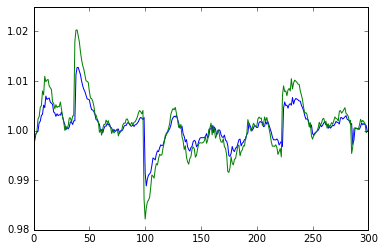

In [79]:
plt.plot(output[:300])
plt.plot(test_data_y[:300])